# Validate datasets

In this notebook example, we are going to generate the validation report, which contains types of anomaly data regarding to https://openvinotoolkit.github.io/datumaro/docs/user-manual/command-reference/validate. Through this, we can identify which data was inapplicable for DL workflow because it is broken or undefined. Moreover, we detect imbalanced, out-of-distributed, or rare samples together.

## Prerequisite
### Download COCO 2017 validation dataset

Please refer https://github.com/openvinotoolkit/datumaro/blob/develop/notebooks/03_visualize.ipynb for preparing COCO 2017 validation dataset.

In [17]:
# Copyright (C) 2022 Intel Corporation
#
# SPDX-License-Identifier: MIT

import datumaro as dm

dataset = dm.Dataset.import_from('coco_dataset', format='coco_instances')

subset = list(dataset.subsets().keys())[0] # val2017
dataset = dm.Dataset(dataset.get_subset(subset))

print('Representation for sample COCO dataset')
dataset

Representation for sample COCO dataset


Dataset
	size=5000
	source_path=None
	media_type=<class 'datumaro.components.media.Image'>
	annotated_items_count=4952
	annotations_count=78647
subsets
	val2017: # of items=5000, # of annotated items=4952, # of annotations=78647, annotation types=['mask', 'polygon', 'bbox']
infos
	categories
	label: ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote'

### Generate the validation report

We first generate the validation rerpot with given conditions.

In [30]:
from datumaro.plugins.validators import DetectionValidator

extra_args = {
    "few_samples_thr": 1,
    "imbalance_ratio_thr": 100,
    "far_from_mean_thr": 10.0,
    "dominance_ratio_thr": 0.9,
    "topk_bins": 0.1,
}

validator = DetectionValidator(**extra_args)
reports = validator.validate(dataset)

print('Validation report summary')
reports['summary']

Validation report summary


{'errors': 36782, 'warnings': 127}

We here checked that most of errors are coming from the `UnderfinedAttribute`. Indeed, one of the attributes of MS-COCO dataset, i.e., `is_crowd`, is not defined in metadata. We provided the description for error or warning analysis.

In [110]:
err_cnt = {}
for report in reports['validation_reports']:
    if report['severity'] == 'error':
        type = report['anomaly_type']
        if err_cnt.get(type) is None:
            err_cnt[type] = 1
        else:
            err_cnt[type] += 1
print("The number of errors per error type: ", err_cnt)

for report in reports['validation_reports']:
    if report['anomaly_type'] == 'UndefinedAttribute':
        print("Description for UndefinedAttribute: ", report['description'])
        break

The number of errors per error type:  {'NegativeLength': 1, 'UndefinedAttribute': 36781}
Description for UndefinedAttribute:  Item has the attribute 'is_crowd' for the label 'bottle' which is not defined in metadata.


{'anomaly_type': 'NegativeLength', 'description': "Annotation '2202383' in the item should have a positive value of 'bounding box height' but got '0.86'.", 'severity': 'error', 'item_id': '000000361919', 'subset': 'val2017'}


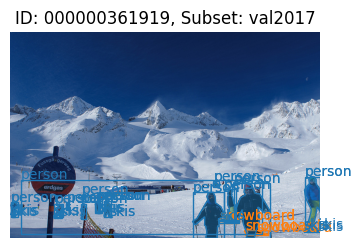

In [111]:
from datumaro.components.visualizer import Visualizer

visualizer = Visualizer(dataset, figsize=(4, 4), alpha=0.5)

for report in reports['validation_reports']:
    if report['anomaly_type'] == 'NegativeLength':
        print(report)
        fig = visualizer.vis_one_sample(id=report['item_id'], subset=report['subset'])
        fig.show()

In COCO val2017 data, there is no invalid item of having negative value or undefined category.

In [85]:
print('Invalid item list')
reports['statistics']['items_with_invalid_value']

Invalid item list


{}

We can find the missing annotated data as below.

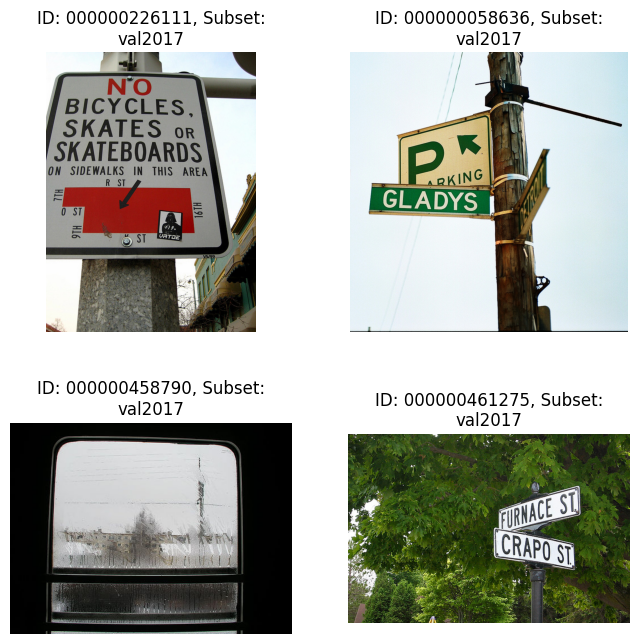

In [32]:
from datumaro.components.visualizer import Visualizer

items_missing_annotation = reports['statistics']['items_missing_annotation']

visualizer = Visualizer(dataset, figsize=(8, 8), alpha=0.5)
ids = []
for id in items_missing_annotation:
    ids.append(id[0])

fig = visualizer.vis_gallery(ids=ids[:4], subset=subset)
fig.show()

From the validation report, we can get access to the distributions of the width and height for each class. For instance, we drew the histograms of the bottle class's width and height as below.

[Text(0.5, 0, 'Bbox height size')]

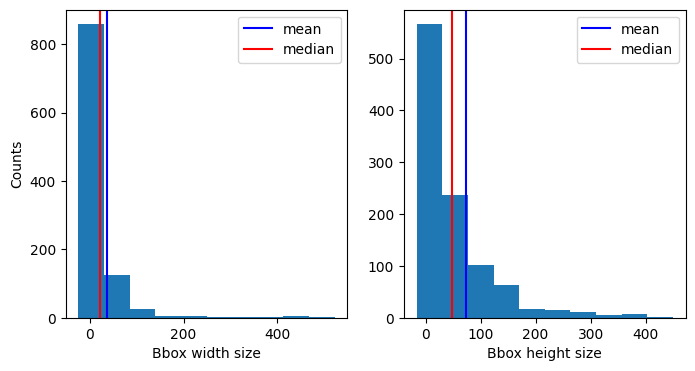

In [83]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import numpy as np

bbox_distribution_in_label = reports['statistics']['bbox_distribution_in_label']

class_name = 'bottle'
bbox_dist_bottle = bbox_distribution_in_label[class_name]

width_counts = bbox_dist_bottle['width']['histogram']['counts']
width_bins = bbox_dist_bottle['width']['histogram']['bins']

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].bar(width_bins[:-1], width_counts, width=np.diff(width_bins))
axes[0].axvline(bbox_dist_bottle['width']['mean'], color='b', label='mean')
axes[0].axvline(bbox_dist_bottle['width']['median'], color='r', label='median')
axes[0].legend(bbox_to_anchor = (1.0, 1))
axes[0].set(xlabel='Bbox width size', ylabel='Counts')

height_counts = bbox_dist_bottle['height']['histogram']['counts']
height_bins = bbox_dist_bottle['height']['histogram']['bins']

axes[1].bar(height_bins[:-1], height_counts, width=np.diff(height_bins))
axes[1].axvline(bbox_dist_bottle['height']['mean'], color='b', label='mean')
axes[1].axvline(bbox_dist_bottle['height']['median'], color='r', label='median')
axes[1].legend(bbox_to_anchor = (1.0, 1))
axes[1].set(xlabel='Bbox height size')